# Introduction

In this project, we will implement a tags recommendation system for *StackOverflow* questions.\
*StackOverflow* is a reknown platform for questions and answers about programmation.
* In the first notebook, we will extract the required data using the *StackExchange data explorer* tool, and explore the data.
* In the second notebook, we will implement various *machine learning algorithms* and select the suitable inference model to deploy an *API endpoint*.

# Environment

In [1]:
import pandas as pd
import numpy as np
from nltk.probability import FreqDist
from IPython.display import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import recall_score,  hamming_loss, jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from DataGT.PCA import display_scree_plot
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import TfidfModel
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from imp import reload
from xgboost import XGBClassifier
from ttictoc import tic, toc
from joblib import dump

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('./data/df.csv', index_col=0)

df.head()

,Title,Body,Tags,Body_tokens,Title_tokens,Tags_tokens,Title_Body_tokens
Id,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"use,change,opacity,code,application,error,work...",convert,"c#,floating-point,type-conversion,double,decimal","convert,use,change,opacity,code,application,er..."
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"value,display,time,hour,day,month","calculate,time","c#,datetime,time,datediff,relative-time-span","calculate,time,value,display,time,hour,day,month"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,web,server,determine,user,timezone,page,he...","determine,user,timezone","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone,way,web,server,determi..."
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"way,obtain,value,π,challenge,way,involve,const...","way,get,value,π","performance,algorithm,language-agnostic,unix,pi","way,get,value,π,way,obtain,value,π,challenge,w..."
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"issue,socket,work,c++,z/os,get,time,error,some...","use,c,socket,api,c++,z/os","c++,c,sockets,mainframe,zos","use,c,socket,api,c++,z/os,issue,socket,work,c+..."


# Preprocessing

In order to pass our data to the various models, we need to process it and transform it into numerical features.
* First, we apply a split to generate a *traning* and a *test set*. The transformers will be fit on the training data to transform the test data, thus avoiding *data leakage*.
* In order to limit dimensionality, we detect the terms with the highest frequencies on the train set and keep the corresponding terms in the test set. We apply this methodology for both the question *content* and *tags*.
* We filter the *corpus* in order to keep the documents that have at least 3 *top tags* to improve the performance of the models.
* We vectorize the *content* using a *TfidVectorizer*.
* We vectorize the *tags* using a *MultiLabelBinarizer*.
* In order to further reduce dimentionality, we apply a *TruncatedSVD* on the question *content* vectors.

The following schema sums up the applied transformations:

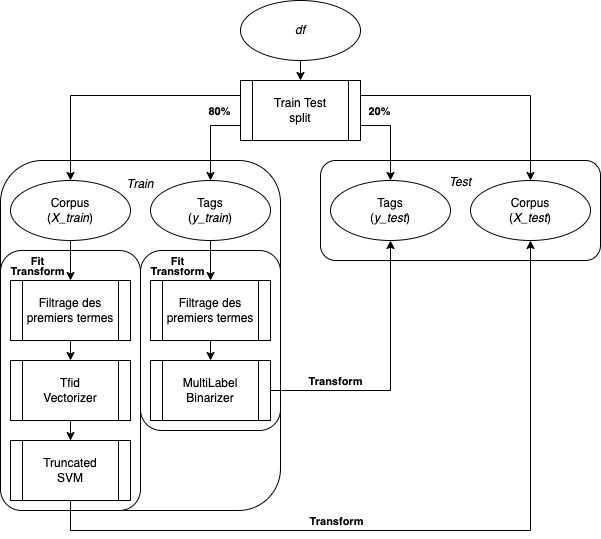

In [3]:
Image(filename='./assets/processing.png')

In [4]:
def gen_frequencies(series):

    dist = FreqDist(','.join(series).split(','))

    return dist

We create a function to extract the top terms from the frequencies dictionary:

In [5]:
def extract_top(frequencies:dict, n_top:int):

    top_values = pd.DataFrame(
        {'Tag':frequencies.keys(), 'Frequency':frequencies.values()}
        ).sort_values('Frequency', ascending=False).head(n_top)['Tag'].values
    
    return top_values

We create a function to keep only the top terms for each value of a *series*:

In [6]:
def keep_top(series:pd.Series, top_values:list):
    
    series = series.apply(lambda cell: list(set(cell.split(',')).intersection(top_values)))

    return series

We develop a *python class* to:
* Fit the transformers,
* Transform the dataset,
* Transform the predictions of the models back into human readable format.

We dispose of a limited processing power and choose to generate a *X set* with 600 features reduced to 350, and a *y set* 200 *tags*:

In [7]:
class DatasetTransformer():

    def __init__(self, df:pd.DataFrame, X:str, y:str):

        self.dataset = df
        self.X = X
        self.y = y
        self.X_values = df[X]
        self.y_values = df[y]
        self.test_df = None
        self.multi_label_binarizer = None
        self.tfid_vectorizer = None
        self.truncated_svd = None
    
    def gen_train_test(self, top_tags, max_features, n_components=None, dimensional_red=True):
        
        # Apply a train test split on the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_values,
            self.y_values,
            test_size=0.2,
            random_state=42)
        
        # y processing

        # Calculate the tags frequencies
        y_frequencies = gen_frequencies(y_train)
        # Extract the top tags
        self.top_tags = extract_top(y_frequencies, top_tags)
        # Keep only the top tags from the target
        y_train = keep_top(y_train, self.top_tags)
        y_test = keep_top(y_test, self.top_tags)

        # Drop the empty rows with to few filtered tags
        train_drop = y_train[y_train.map(len) <= 3].keys()
        test_drop = y_test[y_test.map(len) <= 3].keys()
        y_train.drop(train_drop,inplace=True)
        y_test.drop(test_drop,inplace=True)

        self.X_train_raw = X_train
        self.X_test_raw = X_test
        self.y_train_raw = y_train
        self.y_test_raw = y_test

        print(f'Dropped Train samples: {train_drop.shape[0]}')
        print(f'Dropped Test samples: {test_drop.shape[0]}')

        # Binarize the target
        self.multi_label_binarizer = MultiLabelBinarizer(classes=self.top_tags)
        y_train_matrix = self.multi_label_binarizer.fit_transform(y_train)
        y_test_matrix = self.multi_label_binarizer.transform(y_test)
        
        # Convert the matrixes back to pandas DataFrames
        tags = self.multi_label_binarizer.classes_
        y_train_df = pd.DataFrame(
            data=y_train_matrix,
            index=y_train.index,
            columns=tags)
        y_test_df = pd.DataFrame(
            data=y_test_matrix,
            index=y_test.index,
            columns=tags)

        # Extract the y data to join predictions later
        self.test_df = self.dataset.loc[y_test_df.index, :]
        self.test_df['Tags_target'] = y_test.str.join(',')

        # X processing

        X_train.drop(train_drop, inplace=True)
        X_test.drop(test_drop, inplace=True)
        # Keep the terms with the top frequencies using the max_features arg
        self.tfid_vectorizer = TfidfVectorizer(max_features=max_features)
        # Fit and transform with the Tfid vectorizer on X train
        self.X_train_matrix = self.tfid_vectorizer.fit_transform(X_train)
        # Transform X test
        self.X_test_matrix = self.tfid_vectorizer.transform(X_test)

        # Convert matrixes to dataframe to be used with the Random Forest
        features = self.tfid_vectorizer.get_feature_names_out()
        X_train_df = pd.DataFrame(
            data=self.X_train_matrix.toarray(),
            index=X_train.index,
            columns=features)
        X_test_df = pd.DataFrame(
            data=self.X_test_matrix.toarray(),
            index=X_test.index,
            columns=features)

        if dimensional_red:
            # Apply TruncatedSVD to reduce dimentionality
            self.truncated_svd = TruncatedSVD(n_components=n_components)
            self.X_train_matrix = self.truncated_svd.fit_transform(self.X_train_matrix)
            # Transform X test
            self.X_test_matrix = self.truncated_svd.transform(self.X_test_matrix)

            explained_variance = round(sum(
                self.truncated_svd.explained_variance_ratio_), 2)
            print(f'TruncatedSVD explained variance ratio: {explained_variance}')

            # Convert the matrixes back to pandas DataFrames
            components = list(range(n_components))
            features = self.tfid_vectorizer.get_feature_names_out()
            X_train_df = pd.DataFrame(
                data=self.X_train_matrix,
                index=X_train.index,
                columns=components)
            X_test_df = pd.DataFrame(
                data=self.X_test_matrix,
                index=X_test.index,
                columns=components)

        print(f'Train size: {X_train.shape[0]}')
        print(f'Test size: {X_test.shape[0]}')

        return X_train_df, X_test_df, y_train_df, y_test_df

    def join_predictions(self, name:str, predictions:np.array):

        # Use the binarizer to inverse transform the prediction array
        predictions = self.multi_label_binarizer.inverse_transform(predictions)
        # Add the predictions to the dataset
        self.test_df[name] = predictions

        return self.test_df[[self.X, self.y, 'Tags_target', name]]
    
    def get_predictions(self):

        return self.test_df


transformer = DatasetTransformer(df, 'Title_Body_tokens', 'Tags_tokens')
X_train, X_test, y_train, y_test = transformer.gen_train_test(250, 1250, 990)

Dropped Train samples: 30000
Dropped Test samples: 7505
TruncatedSVD explained variance ratio: 0.96
Train size: 10000
Test size: 2495


We plot the scree plot of the *TruncatedSVD*. The *TruncatedSVD* is considered fit once it reaches an explained variance ratio of 0.8, however we will fit voluntarily fit at more than 0.95 of explained variance, in order to loose a minimal amount of information (which in this case would be detrimental to our models).

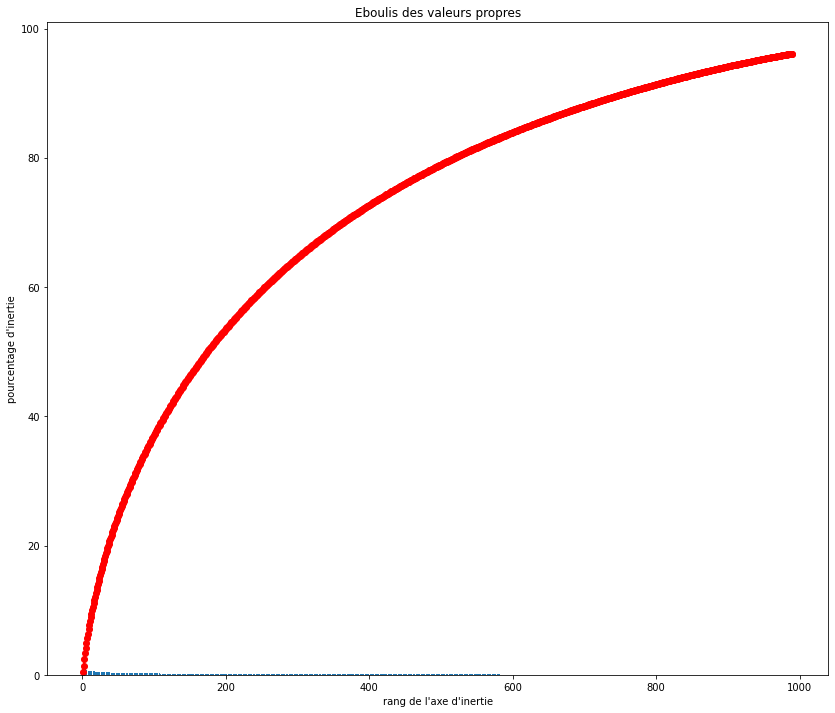

In [8]:
display_scree_plot(transformer.truncated_svd)

# Evaluation

For each experiment, we will calculate the following metrics:
* *sampled Jaccard*: 
* *weighted Recall*: our objective is to minimize the number of *false negatives*, which would result in a higher *recall* score. We are facing and imbalanced repartition of classes, therefore we will use the *weighted* version of the score.
* *ratio of target tags hit*: in combination with the *recall score*, we will compute the number of tags that have been found amongst the filtered *tags*, the equivalent of the accuracy for each document, and calcalute its *mean* as the *ratio of tags hit*,
* *ratio of tags hit*: we use use the same approach on the initial *tags*, which haven't been filtered in order to get an evaluation of how many actual *tags* are predicted,
* *inference time*: the average time to infer a document of the *test set* in seconds,
* *model size*: the size of the model in megabytes.

We create a class to evaluate and keep track of our experiments results:

In [9]:
def count_values(y_true, y_hat):

    y_true = y_true.split(',')
    y_hat = list(y_hat)[:5]
    score_max = len(y_true)
    score = 0

    for pred in y_hat:

        if pred in y_true:

            score += 1

    return score / score_max


class PerformanceReport():

    def __init__(self, true:str, target:str):
        
        # Initialize our report DataFrame
        self.y_true = true
        self.y_target = target
        self.columns = [
            'Jaccard',
            'Recall',
            'Inference_time',
            'Model_size_mb',
            'Targets_hit',
            'Tags_hit',
            'Fill']
        self.report = pd.DataFrame(columns=self.columns)

    def evaluate(self, name:str, model, X_test:np.array, y_true:np.array, y_pred:np.array):
        
        # Predict with the model
        tic()
        model.predict(X_test)
        # Calculate time spent
        inference_time = toc() / X_test.shape[0]
        # Dump model to disk
        dump(model, './data/model.joblib')
        # Get model file size
        model_size = round(os.path.getsize('./data/model.joblib') / 1000000)
        # Calculate the scores
        recall = recall_score(y_true, y_pred, average='weighted')
        jaccard = jaccard_score(y_true, y_pred, average='samples')

        # Append the scores to our report
        self.report.loc[name,self.columns[:4]] = [
            jaccard,
            recall,
            inference_time,
            model_size]
            
        print(pd.DataFrame(self.report.loc[name,self.columns[:4]]))

    def tags_ratio(self, name:str, df:pd.DataFrame):

        tags_hit = df.apply(lambda x: count_values(x[self.y_true], x[name]), axis=1)
        self.report.loc[name, 'Tags_hit'] = np.mean(tags_hit)
        targets_hit = df.apply(lambda x: count_values(x[self.y_target], x[name]), axis=1)
        self.report.loc[name, 'Targets_hit'] = np.mean(targets_hit)
        filled_ratio = df[name].apply(len).sum() / df[self.y_target].str.split(',').apply(len).sum()
        self.report.loc[name, 'Fill'] = np.mean(filled_ratio)
        print(f"Ratio of target tags hit: {round(self.report.loc[name,'Targets_hit'], 4)}")
        print(f"Ratio of tags hit: {round(self.report.loc[name,'Tags_hit'], 4)}")
        print(f"Average fill: {round(self.report.loc[name,'Fill'], 4)}")

    def clean_files(self):

        os.remove('./data/model.joblib')

    def get(self):

        return self.report


report = PerformanceReport(true='Tags_tokens', target='Tags_target')

# Modelling

## Unsupervised

### LDA

For the preprocessing of the data used by the *LDA model*, we are going to use the included *gensim* library methods.\
Moreover, we will not be able to calculate the standard metrics that we choosed to compare the *supervised machine learning algorithms* as we do not use the *y* data for predicting.

We create a *dictionary* with the training data and convert it to a *bag of words corpus*:

In [10]:
texts_train = transformer.X_train_raw.str.split(',')
texts_train.values[0][:10]  # First 10 terms of the first document

['.net',
 'thread',
 'exception',
 'interface',
 'ipoller',
 'implementation',
 'process',
 'take',
 'ipoller',
 'start']

In [11]:
dictionary = corpora.Dictionary(texts_train)
# We keep the 990 most frequent terms (as with the supervised learning)
dictionary.filter_extremes(keep_n=990)
corpus_train = [dictionary.doc2bow(text) for text in texts_train]
corpus_train[0][:10]  # First 10 terms of the first document

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 3),
 (6, 1),
 (7, 2),
 (8, 1),
 (9, 1)]

We transform the test data using the training *dictionary*:

In [12]:
texts_test = transformer.X_test_raw.str.split(',')
corpus_test = [dictionary.doc2bow(text) for text in texts_test]
corpus_test[0]  # First 10 terms of the first document

[(40, 1), (166, 1), (221, 1), (305, 1), (458, 1), (509, 1), (774, 2)]

We test various N topics in order to calculate the coherence and perplexity scores:

In [13]:
TOPICS_RANGE = list(range(1, 50, 1))
coherence_scores = list()
perplexity_scores = list()
models = list()

for n_topics in TOPICS_RANGE:

    # Fit a LDA model for each n_topics
    lda_model = LdaMulticore(
        corpus=corpus_train,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        passes=10,
        workers=24)
    models.append(lda_model)

    perplexity_scores.append(lda_model.log_perplexity(corpus_train))

    # Fit a coherence model for each n_topics to calculate the score
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=texts_train,
        dictionary=dictionary,
        coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

# Plot the results
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=TOPICS_RANGE, y=coherence_scores, name='Coherence'),
    secondary_y=False)
fig.add_trace(
    go.Scatter(x=TOPICS_RANGE, y=perplexity_scores, name='Perplexity'),
    secondary_y=True)
fig.update_layout(title_text=f"Scores per n topics")
fig.update_xaxes(title_text='n topics')
fig.update_yaxes(title_text="Coherence score", secondary_y=False)
fig.update_yaxes(title_text="Perplexity score", secondary_y=True)
fig.update_layout(height=600)
fig.show()

The coherence score hits an optimum with 14 topics, we fit a model accordingly:

In [14]:
lda_model = LdaMulticore(
    corpus=corpus_train,
    id2word=dictionary,
    num_topics=14,
    random_state=42,
    passes=10,
    workers=24)

We can display the generated *topics* and their *term frequencies* using the pyLDAvis library:

In [15]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_train, dictionary)
pyLDAvis.display(lda_display)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Ca

In order to compare the predictions of the *LDA* to the *supervised machine learning*, we fit a model with 250 *topics*:

In [16]:
lda_model = LdaMulticore(
    corpus=corpus_train,
    id2word=dictionary,
    num_topics=250,
    random_state=42,
    passes=10,
    workers=24)

In order to use the *LDA* model to make predictions, we develop a function to select 5 predictions by prioritizing the 50 terms (with the highest probabilities) that are present in the *title* of the question.\
If this does not make up for 5 *tags*, we select the terms with the highest frequencies until we obtain 5 terms.

In [17]:
def filter_preds(document, preds, length=5, top_n=50):
    
    filtered_preds = list()

    if type(document) == float:

        pass

    else:

        for pred in preds[:top_n]:

            if pred in document:

                filtered_preds.append(pred)
                preds.remove(pred)

        filtered_preds = filtered_preds[:length]

    for pred in preds:

        if len(filtered_preds) == length:
            
            break
        
        else:

            filtered_preds.append(pred)
    
    return filtered_preds

We filter the *document topics* to select the first *topic* for each *document*:

In [18]:
topics = [sorted(topic, key=lambda tup: tup[1])[-1][0] for topic in lda_model.get_document_topics(corpus_test)]
topics[:10]  # First 10 documents

[151, 7, 46, 217, 147, 58, 196, 65, 224, 123]

We select the first 50 *terms* for each *topic* and convert their *ids* back to words using the *dictionary*:

In [19]:
preds = [[dictionary[tag[0]] for tag in lda_model.get_topic_terms(topicid=topic, topn=50)] for topic in topics]
preds[0][:10]  # First 10 predictions of the first document

['pointer',
 'vector',
 'plan',
 'execution',
 'use',
 'c++',
 'inheritance',
 'function',
 'case',
 'work']

We then apply the *filter_preds* function described above and add them to the results dataframe:

In [20]:
transformer.test_df['LDA'] = preds
# We apply our filtering function
transformer.test_df['LDA'] = transformer.test_df.apply(lambda x: filter_preds(transformer.top_tags, x['LDA']), axis=1)
transformer.test_df[['Title_tokens', 'Tags_tokens', 'Tags_target', 'LDA']]

,Title_tokens,Tags_tokens,Tags_target,LDA
Id,,,,
1475635,"pointer,structure","c,pointers,variables,struct,return","struct,pointers,c,variables","[vector, c++, inheritance, function, object]"
190666,"linq,sql,concurrency,issue","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","[sql, linq, database, performance, null]"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging","[build, xcode, java, performance, configuration]"
1662904,"qt,setting","c++,windows,linux,qt,qt4","qt,c++,windows,linux","[time, qt, javascript, java, winforms]"
116701,"program,background","windows,linux,macos,shell,background","shell,windows,macos,linux","[process, .net, time, difference, program]"
...,...,...,...,...
5588143,"code,json,reference,serialization,error","c#,json,entity-framework,serialization,asp.net...","c#,asp.net-mvc-3,json,entity-framework,seriali...","[java, exception, object, time, asp.net]"
919287,"wcf,window,service,timeout",".net,windows,wcf,web-services,exception-handling","web-services,.net,exception-handling,wcf,windows","[wcf, soap, rest, .net, class]"
4730570,"list,moq","c#,.net,unit-testing,mocking,moq","c#,unit-testing,.net,mocking","[list, listview, object, linq, class]"


We can still calculate the *ratio of tags hit* using our *PerformanceReport* class:

In [21]:
report.tags_ratio('LDA', transformer.test_df)

Ratio of target tags hit: 0.163
Ratio of tags hit: 0.138
Average fill: 1.1848


# Supervised

### Logistic Regression

Using the *OneVsRest* (or *OneVsAll*) strategy, we can fit a binary classifier for each *label* of the dataset. We obtain a classifier that can output multiple *labels* for each document.

In [22]:
logr_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
logr_model.fit(X_train, y_train)
preds = logr_model.predict(X_test)
report.evaluate('LogR', logr_model, X_test, y_test, preds)

                    LogR
Jaccard         0.249908
Recall          0.268402
Inference_time  0.000368
Model_size_mb          2


In [23]:
transformer.join_predictions('LogR', preds).head()

,Title_Body_tokens,Tags_tokens,Tags_target,LogR
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++, c, pointers)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#, linq)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging",()
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(c++, qt)"
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux","(linux, shell)"


In [24]:
report.tags_ratio('LogR', transformer.test_df)

Ratio of target tags hit: 0.2685
Ratio of tags hit: 0.2264
Average fill: 0.3428


### SVM

In [25]:
svm_model = OneVsRestClassifier(LinearSVC())
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)
report.evaluate('SVM', svm_model, X_test, y_test, preds)

                     SVM
Jaccard         0.367723
Recall           0.41153
Inference_time  0.000372
Model_size_mb          2


In [26]:
transformer.join_predictions('SVM', preds).head()

,Title_Body_tokens,Tags_tokens,Tags_target,SVM
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++, c, pointers, struct)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#, sql, linq, linq-to-sql)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging","(xcode,)"
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(c++, qt)"
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux","(linux, shell)"


In [27]:
report.tags_ratio('SVM', transformer.test_df)

Ratio of target tags hit: 0.4102
Ratio of tags hit: 0.3455
Average fill: 0.5616


### SGD

In [28]:
sgd_model = OneVsRestClassifier(SGDClassifier(loss='modified_huber'), n_jobs=-1)
sgd_model.fit(X_train, y_train)
preds = sgd_model.predict(X_test)
report.evaluate('SGD', sgd_model, X_test, y_test, preds)

                     SGD
Jaccard         0.366004
Recall          0.417798
Inference_time  0.000373
Model_size_mb          2


In [29]:
transformer.join_predictions('SGD', preds).head()

,Title_Body_tokens,Tags_tokens,Tags_target,SGD
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++, c, pointers, struct)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#, sql, linq, linq-to-sql)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging","(xcode,)"
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(c++, qt)"
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux","(linux, bash, shell, asynchronous)"


We notice that some *documents* have empty predictions.\
This behavior is unwanted, as we want to offer predictions for all the questions passed to the model. We will try to remediate to this issue in the next part.

In [30]:
report.tags_ratio('SGD', transformer.test_df)

Ratio of target tags hit: 0.416
Ratio of tags hit: 0.3504
Average fill: 0.593


### KNN

In [31]:
knn_model = KNeighborsClassifier(n_neighbors=25, leaf_size=90, metric='euclidean')
knn_model.fit(X_train.values, y_train.values)
preds = knn_model.predict(X_test)
report.evaluate('KNN', knn_model, X_test, y_test, preds)

                     KNN
Jaccard         0.147249
Recall          0.153481
Inference_time  0.002046
Model_size_mb         99


In [32]:
transformer.join_predictions('KNN', preds).head()

,Title_Body_tokens,Tags_tokens,Tags_target,KNN
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++, c, pointers)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#,)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging",()
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(c++, qt)"
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux","(shell,)"


In [33]:
report.tags_ratio('KNN', transformer.test_df)

Ratio of target tags hit: 0.1536
Ratio of tags hit: 0.1295
Average fill: 0.2022


We obtain interesting results, a few rows have actually been predicted by the model, this is because the model outputs low porbabilities for most of its predictions.

In order to obtain 5 tags, we are going to use the *predict_proba* method to output predictions with lower probability, using the following function:

In [34]:
def get_firsts(preds_proba, n_first=5):

    result = np.array([
        np.where(pred >= np.partition(pred, -n_first)[-n_first], 1, 0)
        for pred in np.array([pred[:,1] for pred in preds_proba
        ]).transpose()])

    return result

In [35]:
preds_proba = knn_model.predict_proba(X_test.values)
preds_firsts = get_firsts(preds_proba)
report.evaluate('KNN_5', knn_model, X_test, y_test, preds_firsts)

                   KNN_5
Jaccard         0.325648
Recall          0.538798
Inference_time  0.002036
Model_size_mb         99


In [36]:
transformer.join_predictions('KNN_5', preds_firsts).head()

,Title_Body_tokens,Tags_tokens,Tags_target,KNN_5
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++, c, arrays, pointers, struct)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#, .net, sql, sql-server, linq-to-sql)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging","(c#, .net, c++, unix, command-line)"
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(c++, windows, visual-studio, user-interface, ..."
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux","(c++, linux, unix, shell, process)"


We observe an *average fill* superior to 1, which is normal, it compares the lenght of the filtered *target tags* to the number of predicted tags, of which we now have 5 for each *document*:

In [37]:
report.tags_ratio('KNN_5', transformer.test_df)

Ratio of target tags hit: 0.4706
Ratio of tags hit: 0.3968
Average fill: 1.3867


### Random Forest

In [38]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)
preds = rfc_model.predict(X_test)
preds_proba = rfc_model.predict_proba(X_test)
report.evaluate('Random_Forest', rfc_model, X_test, y_test, preds)

               Random_Forest
Jaccard             0.020073
Recall               0.01985
Inference_time      0.000841
Model_size_mb           5044


In [39]:
transformer.join_predictions('Random_Forest', preds).head()

,Title_Body_tokens,Tags_tokens,Tags_target,Random_Forest
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++,)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency",()
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging",()
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux",()
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux",()


In [40]:
report.tags_ratio('Random_Forest', transformer.test_df)

Ratio of target tags hit: 0.0202
Ratio of tags hit: 0.0168
Average fill: 0.0236


In [41]:
preds_firsts = get_firsts(preds_proba, 5)
report.evaluate('Random_Forest_5', rfc_model, X_test, y_test, preds_firsts)

               Random_Forest_5
Jaccard               0.266762
Recall                0.440878
Inference_time        0.001079
Model_size_mb             5044


In [42]:
transformer.join_predictions('Random_Forest_5', preds_firsts).head()

,Title_Body_tokens,Tags_tokens,Tags_target,Random_Forest_5
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c#, c++, c, arrays, pointers, struct)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#, java, .net, sql, database)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging","(c#, .net, c++, c, linux)"
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(c#, .net, c++, iphone, objective-c, ios)"
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux","(c++, linux, windows, bash, shell)"


In [43]:
preds_df = transformer.test_df
report.tags_ratio('Random_Forest_5', transformer.test_df)

Ratio of target tags hit: 0.417
Ratio of tags hit: 0.3515
Average fill: 1.2591


#### *High-end Random forest*

We noticed that the dimensional reduction was highly detrimental to the *RandomForest* performances. We will fit a high performance model in order to show the performances that can be attained but which we won't be able to deploy because of its size. 

We generate a *dataset* with 250 *tags* and 1250 *features* to train our high-end model:

In [44]:
X_train, X_test, y_train, y_test = transformer.gen_train_test(250, 1250, dimensional_red=False)

Dropped Train samples: 30000
Dropped Test samples: 7505
Train size: 10000
Test size: 2495


In [45]:
rfc_model_he = RandomForestClassifier()
rfc_model_he.fit(X_train, y_train)
preds = rfc_model_he.predict(X_test)
preds_proba = rfc_model_he.predict_proba(X_test)
report.evaluate('Random_Forest_HE', rfc_model_he, X_test, y_test, preds)

               Random_Forest_HE
Jaccard                0.234456
Recall                 0.246082
Inference_time         0.000832
Model_size_mb              5082


In [46]:
transformer.join_predictions('Random_Forest_HE', preds).head()

,Title_Body_tokens,Tags_tokens,Tags_target,Random_Forest_HE
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++, c, pointers)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#, linq)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging","(xcode,)"
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(java,)"
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux",()


In [47]:
report.tags_ratio('Random_Forest_HE', transformer.test_df)

Ratio of target tags hit: 0.2471
Ratio of tags hit: 0.2077
Average fill: 0.3117


In [48]:
preds_firsts = get_firsts(preds_proba, 5)
report.evaluate('Random_Forest_HE_5', rfc_model_he, X_test, y_test, preds_firsts)

               Random_Forest_HE_5
Jaccard                  0.391486
Recall                    0.58638
Inference_time           0.000993
Model_size_mb                5082


In [49]:
transformer.join_predictions('Random_Forest_HE_5', preds_firsts).head()

,Title_Body_tokens,Tags_tokens,Tags_target,Random_Forest_HE_5
Id,,,,
1475635,"pointer,structure,return,pointer,struct,c,mean...","c,pointers,variables,struct,return","struct,pointers,c,variables","(c++, c, arrays, pointers, struct)"
190666,"linq,sql,concurrency,issue,build,order,record,...","c#,linq,linq-to-sql,concurrency,transactions","linq-to-sql,transactions,c#,linq,concurrency","(c#, sql, sql-server, linq, linq-to-sql)"
1735000,"instrument,display,console,command,line,applic...","c,xcode,debugging,macos,instruments","macos,xcode,c,debugging","(iphone, objective-c, macos, xcode, debugging)"
1662904,"qt,setting,part,qt,effort,payback,road,questio...","c++,windows,linux,qt,qt4","qt,c++,windows,linux","(c#, java, .net, c++, user-interface, qt)"
116701,"program,background,way,c,program,command,line,...","windows,linux,macos,shell,background","shell,windows,macos,linux","(c++, linux, windows, bash, shell)"


Thanks to this algorithm, we manage to predict close to 60% of the *filtered tags* and 50% of the *actual tags*.

In [50]:
report.tags_ratio('Random_Forest_HE_5', transformer.test_df)

Ratio of target tags hit: 0.5743
Ratio of tags hit: 0.4838
Average fill: 1.2221


# Exploring the results

In [52]:
report.clean_files()
report.get()

,Jaccard,Recall,Inference_time,Model_size_mb,Targets_hit,Tags_hit,Fill
LDA,NaN,NaN,NaN,NaN,0.163046,0.138036,1.184823
LogR,0.249908,0.268402,0.000368,2,0.268517,0.226373,0.342768
SVM,0.367723,0.41153,0.000372,2,0.4102,0.345491,0.561592
SGD,0.366004,0.417798,0.000373,2,0.416032,0.350381,0.593029
KNN,0.147249,0.153481,0.002046,99,0.153587,0.129539,0.202203
KNN_5,0.325648,0.538798,0.002036,99,0.470561,0.396794,1.386741
Random_Forest,0.020073,0.01985,0.000841,5044,0.02024,0.016754,0.023554
Random_Forest_5,0.266762,0.440878,0.001079,5044,0.417034,0.351503,1.259094
Random_Forest_HE,0.234456,0.246082,0.000832,5082,0.247114,0.207695,0.311711
Random_Forest_HE_5,0.391486,0.58638,0.000993,5082,0.574349,0.483848,1.222148


The *KNN_select* model offers a good performance, a good *recall* score, while remaining of light size, for these reasons we are going to implement this model in our *API*.

The following cell, when executed, pulls a random *sample* from the dataset to explore the behavior of the *KNN_select* (the *supervised tags*, compared to the *LDA unsupervised tags*):

In [53]:
sample = preds_df.sample(1)
print(f"""
    Title raw: {sample['Title'].values[0]}\n\n
    Body tokens: {sample['Body_tokens'].values[0].split(',')}\n\n
    Tags tokens: {sample['Tags_tokens'].values[0].split(',')}\n\n
    Supervised tags tokens: {sample['KNN_5'].values[0]}\n\n
    Unsupervised tags tokens: {sample['LDA'].values[0]}""")


    Title raw: Flipping OpenGL texture


    Body tokens: ['load', 'texture', 'image', 'opengl', 'coordinate', 'system', 'way', 'flip', 'glscalef', '-1.0f', 'coordinate', 'texture', 'reverse', 'image', 'photoshop', 'know', 'method', 'load', 'png', 'texture', 'file', 'textureimage', 'struct', 'height', 'width', '*', 'data', 'right', 'opengl', 'try', 'game', 'cocoa', 'windowing', 'objective-c', 'language', 'thing', 'game', 'pixel', 'unit', 'set', 'origin', 'corner', 'preference', 'problem', 'thing', 'e.g', 'thanks']


    Tags tokens: ['objective-c', 'opengl', 'image', 'macos', 'textures']


    Supervised tags tokens: ('c#', 'javascript', 'jquery', 'image', 'image-processing')


    Unsupervised tags tokens: ['image', 'http', 'browser', 'file', 'html']


We can observe that the *LDA* model mainly pulls generic terms from the *document*, which is not, in our case, a wanted behavior. The *KNN_select* predictions seem way more pertinent.

# Saving files

*For further use*

In [54]:
dump(transformer.multi_label_binarizer, './P5_03_api_code/multi_label_binarizer.joblib')
dump(transformer.tfid_vectorizer, './P5_03_api_code/tfid_vectorizer.joblib')
dump(transformer.truncated_svd, './P5_03_api_code/truncated_svd.joblib')
dump(knn_model, './P5_03_api_code/model.joblib')

['./P5_03_api_code/model.joblib']

# Conclusion

We have succesfully transformed the data in order to train models to suggest *tags* for *StackOverflow* questions.

We have selected a model to deploy to an *API endpoint*.

The model is far from being the best as we were limited in terms of runtime and processing power. In order to obtain a working prototype, we have greatly reduced the data dimensionality.

Of course, several enhancements can be suggested:
* The use of more *training data*,
* A more advance *data preprocessing* with the creation of a handmade *dictionary*,
* The use of a *neuronet*.

*Thank you for readng this project,*

*Thibaud GROSJEAN*
